
# Linear Regression — Life Expectancy (statsmodels)

Follows the lecture 06 checklist: apply the dataset's built-in transforms, build several OLS specifications (main effects, interactions, PCA-reduced features), compare via corrected AIC (AICc), and run residual + multicollinearity diagnostics. All data prep uses the AMA toolbox utilities.


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.regressionplots import influence_plot
from sklearn.model_selection import (
    KFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from patsy import bs, dmatrix
from statsmodels.formula.api import ols
from statsmodels.graphics import gofplots, regressionplots
from statsmodels.stats import diagnostic as sm_diagnostic
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import jarque_bera
from ama_tlbx.plotting import (
    plot_correlation_heatmap,
    plot_group_compression,
    plot_group_loadings,
    plot_group_variance_summary,
    plot_target_correlations,
    plot_top_correlated_pairs,
)

from ama_tlbx.analysis import FeatureGroup
from ama_tlbx.data import LECol, LifeExpectancyDataset


sns.set_theme(style="whitegrid")


In [18]:
le_ds = LifeExpectancyDataset.from_csv(
    aggregate_by_country=2014, resolve_nand_pred="drop"
)
df = le_ds.tf_and_norm().drop(columns=[LECol.YEAR])
df


,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
country,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,59.9,1.008246,1.471512,-0.866227,-0.410361,1.213565,1.026147,-1.059125,1.460888,1.379213,0.821577,1.331756,-0.571266,-0.609920,-0.532322,2.054563,1.956932,-1.284945,-0.976814
Albania,0,77.5,-1.388739,-1.111408,0.813798,0.473724,-1.208615,-0.941088,0.809728,-0.737107,-1.115737,-0.089841,-1.088540,-0.571266,0.471021,-0.579813,-0.991140,-0.957499,0.605782,0.556110
Algeria,0,75.4,-1.361397,0.801188,-0.866227,-0.561474,-0.554050,-0.941088,0.867827,0.734372,-0.466231,0.437196,-0.434484,-0.571266,-0.669998,1.275866,0.664444,0.557845,0.473099,0.629106
Angola,0,51.7,1.710025,1.499430,1.335319,-0.962188,1.163852,2.030888,-0.860620,1.553558,1.131186,-1.108252,1.282081,1.312759,-0.741760,0.264106,1.101253,0.995516,-0.946604,-0.465839
Argentina,0,76.2,-0.386197,0.248134,1.291928,0.816905,-0.408479,-0.721174,1.051807,0.200545,-0.086294,-0.521774,-0.289026,-0.571266,1.000519,1.311523,-1.127469,-1.224576,1.030366,1.687554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uruguay,0,76.8,-0.395312,-1.111408,1.055038,0.513113,-0.554050,-0.941088,1.109906,-1.140931,-0.466231,0.980085,-0.434484,-0.571266,1.168647,0.354488,-0.808291,-0.898005,0.804806,1.030586
Uzbekistan,0,69.2,0.215327,0.641655,-0.866227,-2.400730,-1.591512,-0.243975,0.165797,0.574486,-1.495674,-0.105692,-1.471138,-0.571266,-2.301502,-1.351000,-0.136013,-0.149403,0.134759,-0.210352
Vanuatu,0,71.7,-0.240373,-1.111408,-0.866227,0.612521,1.163852,-0.180308,0.582173,-1.140931,1.212719,-0.359304,1.282081,-0.571266,0.269927,-1.491919,-0.808291,-0.898005,-0.488849,-0.684829


In [25]:
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import influence_plot
from patsy import build_design_matrices


def pred_plot(model, feat, df):
    """Plot fitted line for a single feature for statsmodels OLS (formula or OLS).

    Uses model.exog_names to rebuild the design matrix; other predictors fixed at their means.
    """
    grid = np.linspace(df[feat].min(), df[feat].max(), 300)
    exog_names = model.model.exog_names

    exog_pred = pd.DataFrame(0.0, index=range(len(grid)), columns=exog_names)
    if "const" in exog_names:
        exog_pred["const"] = 1.0

    for name in exog_names:
        if name == "const":
            continue
        if name == feat:
            exog_pred[name] = grid
        elif name in df.columns:
            exog_pred[name] = df[name].astype(float).mean()
        else:
            exog_pred[name] = 0.0

    pred_results = model.get_prediction(exog_pred)
    pred_summary = pred_results.summary_frame()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=feat, y=LECol.TARGET, alpha=0.5)
    plt.plot(grid, pred_summary["mean"], color="red", linewidth=3)
    plt.fill_between(
        grid,
        pred_summary["mean_ci_lower"],
        pred_summary["mean_ci_upper"],
        color="red",
        alpha=0.2,
    )
    plt.xlabel(feat)
    plt.ylabel(LECol.TARGET)
    plt.title("OLS Prediction with 95% CI")
    plt.show()


def residual_diagnostics(
    results: sm.regression.linear_model.RegressionResultsWrapper,
    predictors: list[str],
    max_pred_plots: int = 4,
):
    """Residual diagnostics with robust predictor matching.

    Tries to plot residuals vs predictors in both the provided list and model.exog_names.
    Falls back to first exog columns (excluding const) if no overlap.
    """
    resid = results.resid
    fitted = results.fittedvalues
    influence = results.get_influence()
    student_resid = influence.resid_studentized_internal

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    sns.residplot(x=fitted, y=resid, lowess=True, ax=axes[0, 0], color="tab:blue")
    axes[0, 0].set_title("Residuals vs Fitted")
    axes[0, 0].set_xlabel("Fitted values")
    axes[0, 0].set_ylabel("Residuals")

    sns.scatterplot(
        x=fitted, y=np.sqrt(np.abs(student_resid)), ax=axes[0, 1], color="tab:orange"
    )
    axes[0, 1].set_title("Scale-Location (sqrt|studentized residuals|)")
    axes[0, 1].set_ylabel("sqrt(|studentized resid|)")

    sm.qqplot(student_resid, line="45", fit=True, ax=axes[1, 0])
    axes[1, 0].set_title("QQ plot (studentized residuals)")

    sns.histplot(resid, kde=True, ax=axes[1, 1], color="tab:green")
    axes[1, 1].set_title("Residual distribution")
    axes[1, 1].set_xlabel("Residuals")

    plt.tight_layout()
    plt.show()

    model_preds = [p for p in results.model.exog_names if p != "const"]
    predictors = [str(p) for p in predictors]
    preds_to_plot = [p for p in predictors if p in model_preds][:max_pred_plots]
    if not preds_to_plot:
        preds_to_plot = model_preds[:max_pred_plots]

    if preds_to_plot:
        fig, axes = plt.subplots(1, len(preds_to_plot), figsize=(14, 3))
        if len(preds_to_plot) == 1:
            axes = [axes]
        for ax, pred in zip(axes, preds_to_plot):
            col_idx = results.model.exog_names.index(pred)
            sns.scatterplot(
                x=results.model.exog[:, col_idx],
                y=resid,
                ax=ax,
            )
            ax.set_title(f"Residuals vs {pred}")
        plt.tight_layout()
        plt.show()
    else:
        print("No predictors available for residual-vs-predictor plots.")

    fig = influence_plot(results, criterion="cooks")
    plt.tight_layout()
    plt.show()


def fit_ols(df):
    y = df[LECol.TARGET].astype(float)
    X = df.drop(columns=[LECol.TARGET]).astype(float)
    X = sm.add_constant(X)
    return sm.OLS(y, X).fit()


                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     502.4
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           2.56e-46
Time:                        13:51:13   Log-Likelihood:                -363.32
No. Observations:                 131   AIC:                             730.6
Df Residuals:                     129   BIC:                             736.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

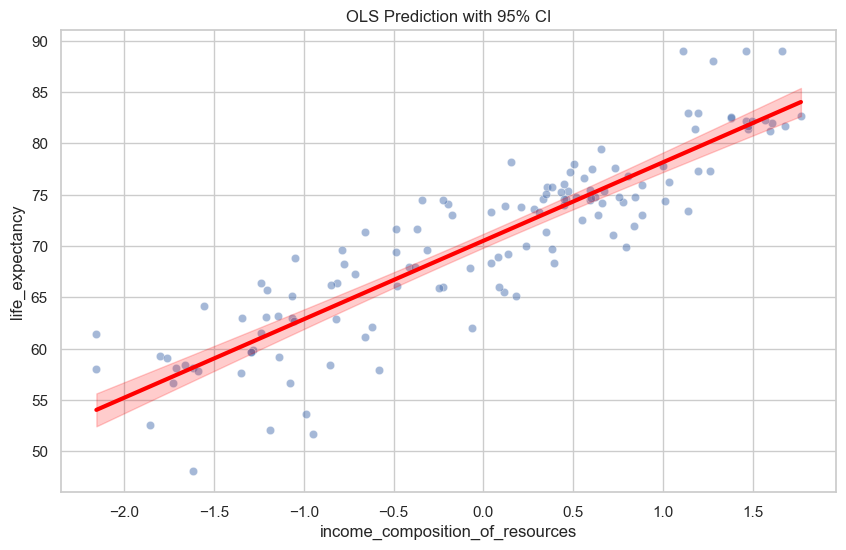

In [26]:
pred = f"{LECol.INCOME_COMPOSITION}"
model = smf.ols(f"life_expectancy ~ {pred}", data=df).fit()

print(model.summary())
pred_plot(model, LECol.INCOME_COMPOSITION, df)


In [27]:
df


,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
country,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,59.9,1.008246,1.471512,-0.866227,-0.410361,1.213565,1.026147,-1.059125,1.460888,1.379213,0.821577,1.331756,-0.571266,-0.609920,-0.532322,2.054563,1.956932,-1.284945,-0.976814
Albania,0,77.5,-1.388739,-1.111408,0.813798,0.473724,-1.208615,-0.941088,0.809728,-0.737107,-1.115737,-0.089841,-1.088540,-0.571266,0.471021,-0.579813,-0.991140,-0.957499,0.605782,0.556110
Algeria,0,75.4,-1.361397,0.801188,-0.866227,-0.561474,-0.554050,-0.941088,0.867827,0.734372,-0.466231,0.437196,-0.434484,-0.571266,-0.669998,1.275866,0.664444,0.557845,0.473099,0.629106
Angola,0,51.7,1.710025,1.499430,1.335319,-0.962188,1.163852,2.030888,-0.860620,1.553558,1.131186,-1.108252,1.282081,1.312759,-0.741760,0.264106,1.101253,0.995516,-0.946604,-0.465839
Argentina,0,76.2,-0.386197,0.248134,1.291928,0.816905,-0.408479,-0.721174,1.051807,0.200545,-0.086294,-0.521774,-0.289026,-0.571266,1.000519,1.311523,-1.127469,-1.224576,1.030366,1.687554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uruguay,0,76.8,-0.395312,-1.111408,1.055038,0.513113,-0.554050,-0.941088,1.109906,-1.140931,-0.466231,0.980085,-0.434484,-0.571266,1.168647,0.354488,-0.808291,-0.898005,0.804806,1.030586
Uzbekistan,0,69.2,0.215327,0.641655,-0.866227,-2.400730,-1.591512,-0.243975,0.165797,0.574486,-1.495674,-0.105692,-1.471138,-0.571266,-2.301502,-1.351000,-0.136013,-0.149403,0.134759,-0.210352
Vanuatu,0,71.7,-0.240373,-1.111408,-0.866227,0.612521,1.163852,-0.180308,0.582173,-1.140931,1.212719,-0.359304,1.282081,-0.571266,0.269927,-1.491919,-0.808291,-0.898005,-0.488849,-0.684829


In [28]:
feature_groups = [
    FeatureGroup(
        name="socio_economic",
        features=[LECol.SCHOOLING, LECol.INCOME_COMPOSITION],
    ),
]


reduced_columns = [feature for g in feature_groups for feature in g.features]

dim_red_result = (
    LifeExpectancyDataset(df=df)
    .make_pca_dim_reduction_analyzer(
        feature_groups=feature_groups, standardized=False, min_var_explained=1.0
    )
    .fit()
    .result()
)

pc_df = dim_red_result.reduced_df.assign(
    life_expectancy=df[LECol.TARGET],
)
model = fit_ols(pc_df)
print(model.summary())


DatasetView should contain standardized features for PCA dimensionality reduction.
                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     251.5
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           4.58e-45
Time:                        13:51:14   Log-Likelihood:                -362.85
No. Observations:                 131   AIC:                             731.7
Df Residuals:                     128   BIC:                             740.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [29]:
feature_groups = [
    FeatureGroup(
        name="socio_economic",
        features=[LECol.SCHOOLING, LECol.INCOME_COMPOSITION, LECol.ALCOHOL],
    ),
]


reduced_columns = [feature for g in feature_groups for feature in g.features]

dim_red_result = (
    LifeExpectancyDataset(df=df)
    .make_pca_dim_reduction_analyzer(
        feature_groups=feature_groups, standardized=False, min_var_explained=1.0
    )
    .fit()
    .result()
)

pc_df = dim_red_result.reduced_df.assign(
    life_expectancy=df[LECol.TARGET],
)
model = fit_ols(pc_df)
print(model.summary())


DatasetView should contain standardized features for PCA dimensionality reduction.
                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     166.4
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           8.19e-44
Time:                        13:51:15   Log-Likelihood:                -362.85
No. Observations:                 131   AIC:                             733.7
Df Residuals:                     127   BIC:                             745.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [30]:
feature_groups = [
    FeatureGroup(
        name="immunization", features=[LECol.POLIO, LECol.DIPHTHERIA, LECol.HEPATITIS_B]
    ),
]


reduced_columns = [feature for g in feature_groups for feature in g.features]

dim_red_result = (
    LifeExpectancyDataset(df=df)
    .make_pca_dim_reduction_analyzer(
        feature_groups=feature_groups, standardized=False, min_var_explained=0.8
    )
    .fit()
    .result()
)

pc_df = dim_red_result.reduced_df.assign(
    life_expectancy=df[LECol.TARGET],
)
model = fit_ols(pc_df)
print(model.summary())


DatasetView should contain standardized features for PCA dimensionality reduction.
                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     36.62
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           1.46e-08
Time:                        13:51:15   Log-Likelihood:                -450.97
No. Observations:                 131   AIC:                             905.9
Df Residuals:                     129   BIC:                             911.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

In [31]:
feature_groups = [
    FeatureGroup(
        name="immunization", features=[LECol.POLIO, LECol.DIPHTHERIA, LECol.HEPATITIS_B]
    ),
]

dim_red_result = (
    LifeExpectancyDataset(df=df)
    .make_pca_dim_reduction_analyzer(
        feature_groups=feature_groups, standardized=False, min_var_explained=0.9
    )
    .fit()
    .result()
)

pc_immu_inc = dim_red_result.reduced_df.assign(
    **df[[LECol.TARGET, LECol.INCOME_COMPOSITION]],
)
model = fit_ols(pc_immu_inc)
print(model.summary())


DatasetView should contain standardized features for PCA dimensionality reduction.
                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     257.7
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           1.32e-45
Time:                        13:51:16   Log-Likelihood:                -361.58
No. Observations:                 131   AIC:                             729.2
Df Residuals:                     128   BIC:                             737.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

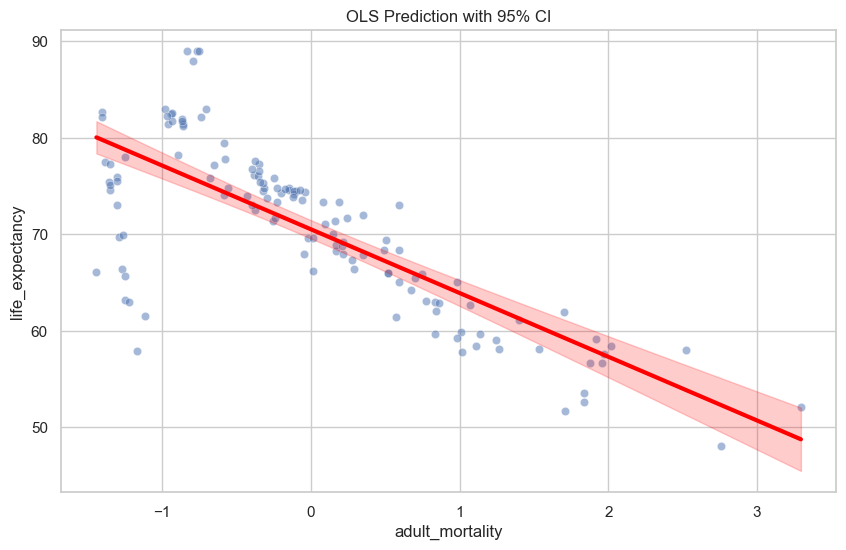

In [32]:
pred = f"{LECol.ADULT_MORTALITY}"
model = smf.ols(f"life_expectancy ~ {pred}", data=df).fit()

pred_plot(model, LECol.ADULT_MORTALITY, df)


In [33]:
feature_groups = [
    FeatureGroup(
        name="econ", features=[LECol.ADULT_MORTALITY, LECol.INCOME_COMPOSITION]
    ),
]

dim_red_result = (
    LifeExpectancyDataset(df=df)
    .make_pca_dim_reduction_analyzer(
        feature_groups=feature_groups, standardized=False, min_var_explained=0.9
    )
    .fit()
    .result()
)

pc_econ = dim_red_result.reduced_df.assign(
    **df[[LECol.TARGET]],
)
model = fit_ols(pc_immu_inc)
print(model.summary())


DatasetView should contain standardized features for PCA dimensionality reduction.
                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     257.7
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           1.32e-45
Time:                        13:51:23   Log-Likelihood:                -361.58
No. Observations:                 131   AIC:                             729.2
Df Residuals:                     128   BIC:                             737.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [34]:
target_cor = (
    LifeExpectancyDataset(df=df)
    .make_correlation_analyzer(standardized=False)
    .fit()
    .result()
    .target_correlations.assign(abs_cor=lambda d: d.correlation.abs())
    .sort_values(by="abs_cor", ascending=False)
    .reset_index(drop=True)
    .query("abs_cor > 0.25")
)
target_cor


,correlation,feature,abs_cor
0,0.892017,income_composition_of_resources,0.892017
1,0.801796,schooling,0.801796
2,-0.770069,adult_mortality,0.770069
3,-0.709995,hiv_aids,0.709995
4,-0.622333,thinness_5_9_years,0.622333
5,-0.589766,under_five_deaths,0.589766
6,-0.585650,thinness_1_19_years,0.585650
7,0.564462,percentage_expenditure,0.564462
8,-0.560274,infant_deaths,0.560274
9,0.557936,alcohol,0.557936


In [35]:
features = target_cor.feature.to_list()
features.remove("status")
feature_groups = [
    FeatureGroup(name="preds", features=features),
]

dim_red_result = (
    LifeExpectancyDataset(df=df)
    .make_pca_dim_reduction_analyzer(
        feature_groups=feature_groups, standardized=False, min_var_explained=1
    )
    .fit()
    .result()
)

drop_pcs = [2, 5, 7, 8, 9, 10, 11, 12, 14, 16]
drop_pcs = [f"preds_PC{k}" for k in drop_pcs]
top_k = dim_red_result.reduced_df.assign(
    **df[[LECol.TARGET]],
).drop(columns=drop_pcs)
display(top_k)
model = fit_ols(top_k)
print(model.summary())


DatasetView should contain standardized features for PCA dimensionality reduction.


,preds_PC1,preds_PC3,preds_PC4,preds_PC6,preds_PC13,preds_PC15,life_expectancy
country,,,,,,,
Afghanistan,-4.124772,0.746845,0.914712,2.053593,-0.088981,-0.023620,59.9
Albania,3.161157,-0.591760,-0.014796,-0.503584,-0.099564,-0.032020,77.5
Algeria,0.139968,-0.818937,1.446408,0.542887,-0.016641,-0.182892,75.4
Angola,-3.782858,1.036123,0.994411,-0.789520,-0.377222,0.056097,51.7
Argentina,2.705368,0.451271,1.382426,-1.226223,-0.305735,0.073310,76.2
...,...,...,...,...,...,...,...
Uruguay,3.253364,0.225201,-0.371432,0.156940,-0.207713,0.426072,76.8
Uzbekistan,-0.668835,-2.226610,0.755424,-1.169681,0.275315,-0.057608,69.2
Vanuatu,0.267584,-1.257735,-1.287729,0.489690,-0.020127,-0.057666,71.7


                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     162.5
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           2.84e-56
Time:                        13:51:25   Log-Likelihood:                -324.43
No. Observations:                 131   AIC:                             662.9
Df Residuals:                     124   BIC:                             683.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.5198      0.259    272.711      0.0

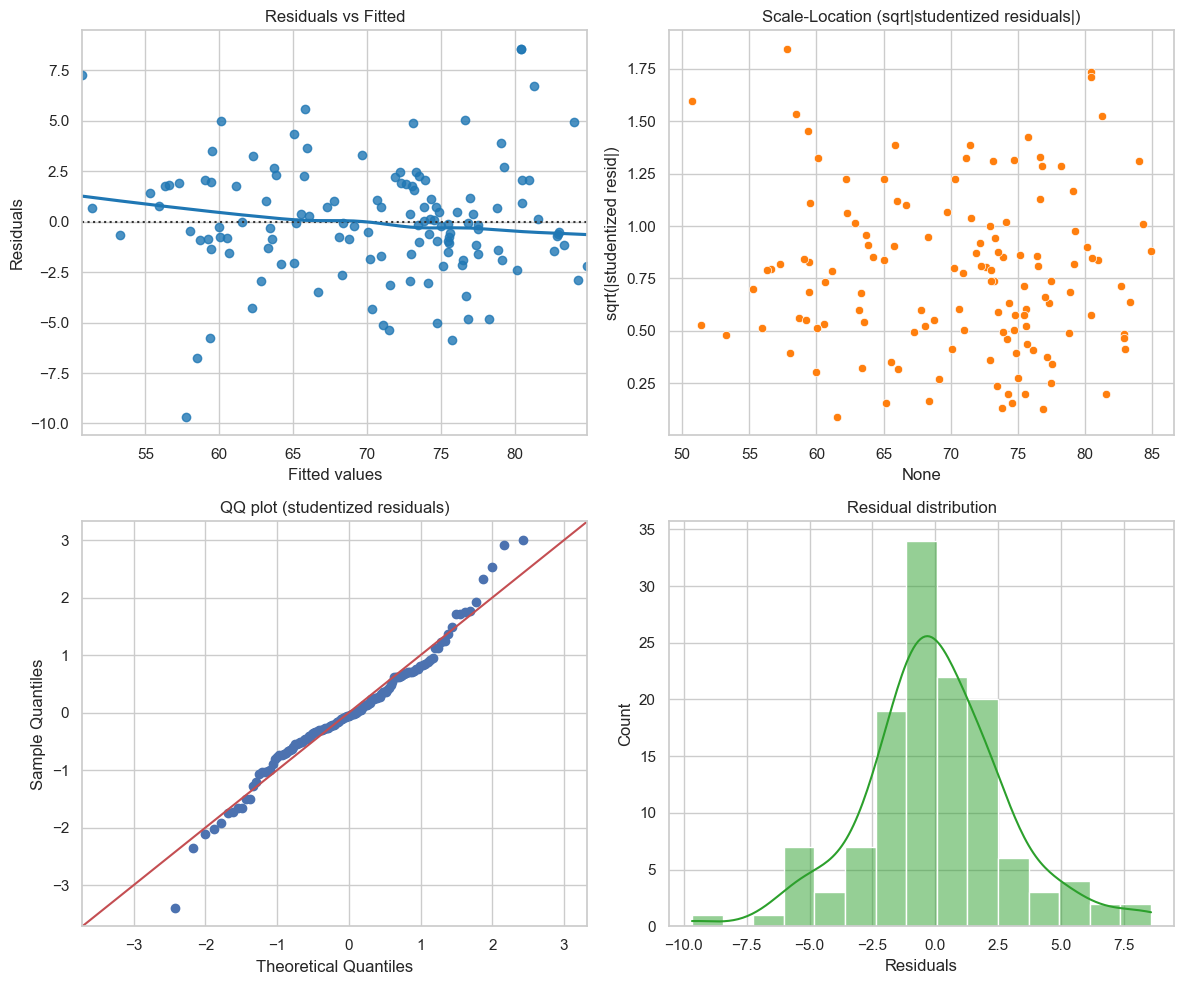

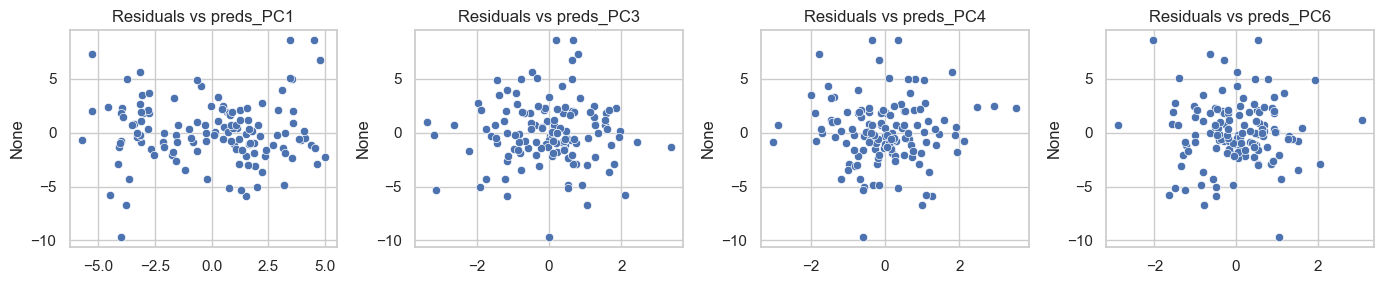

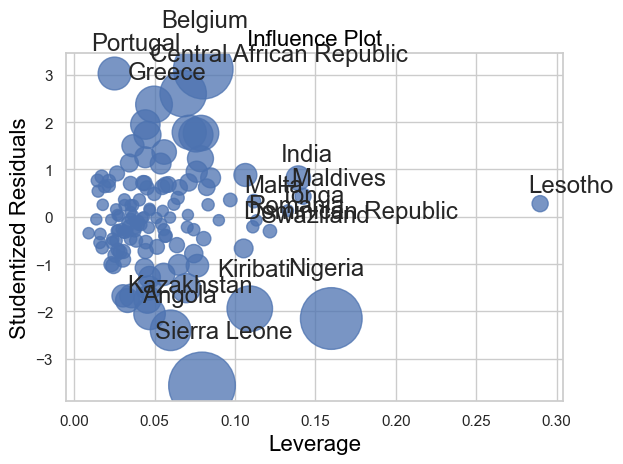

In [36]:
residual_diagnostics(model, predictors=features)


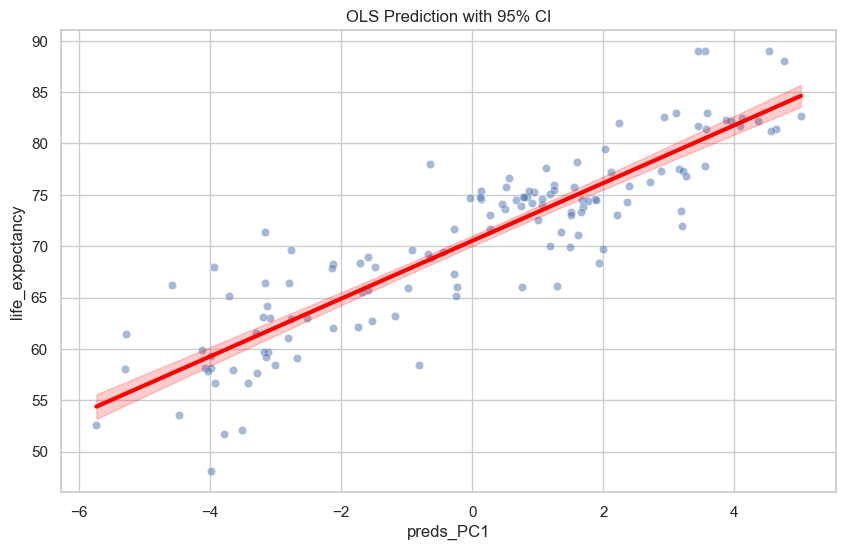

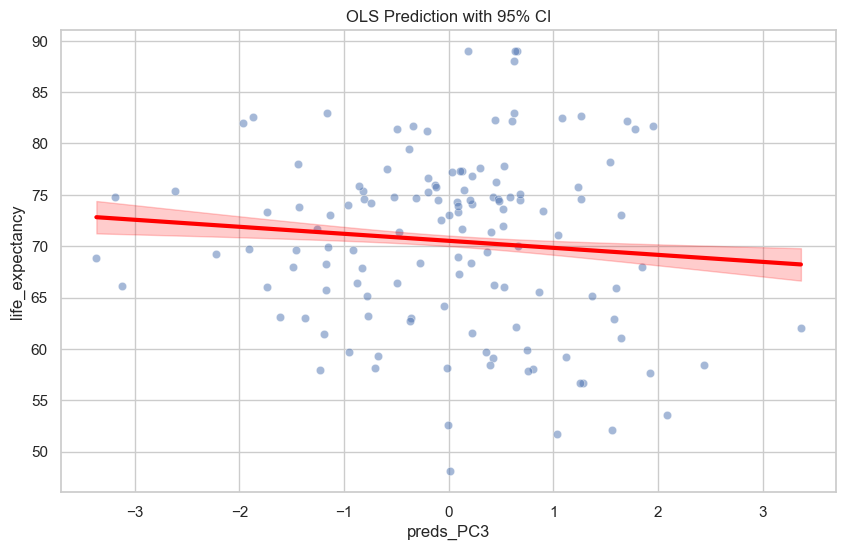

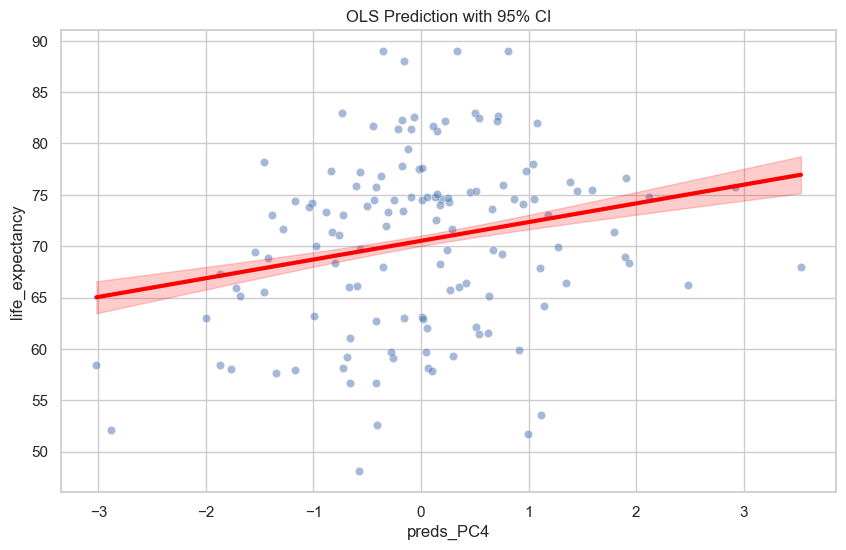

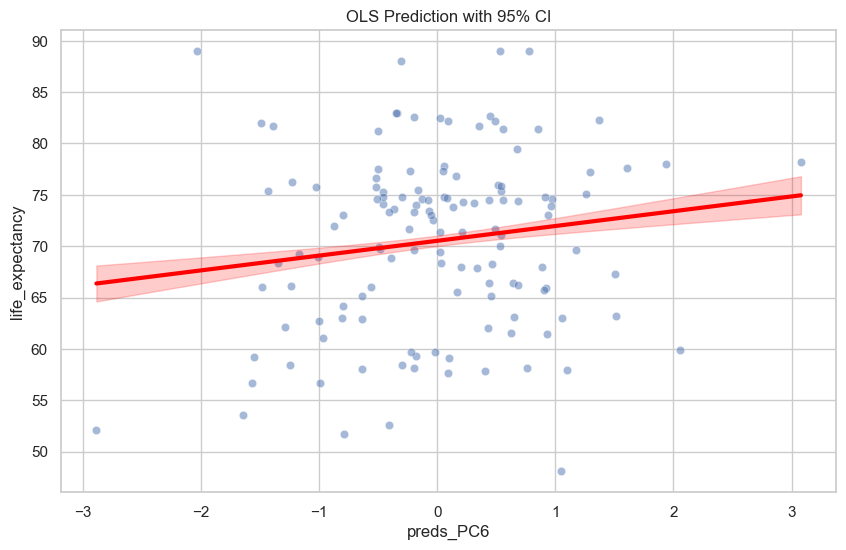

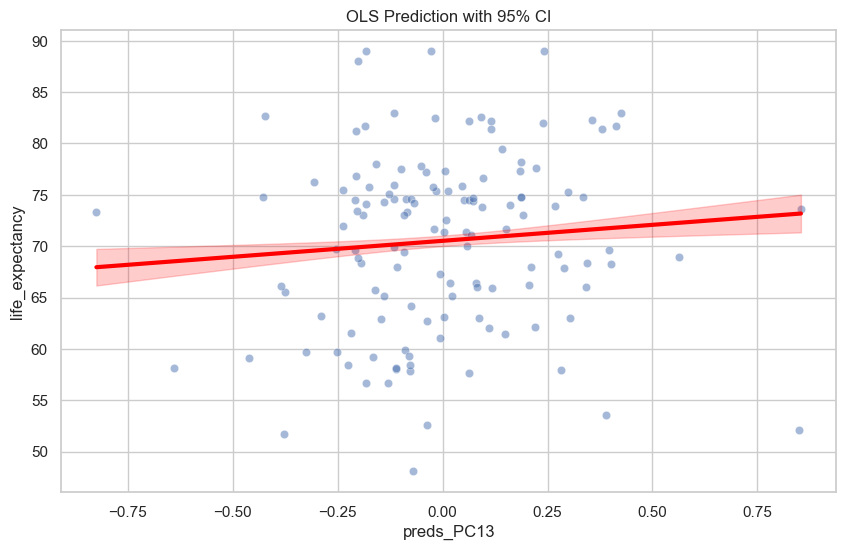

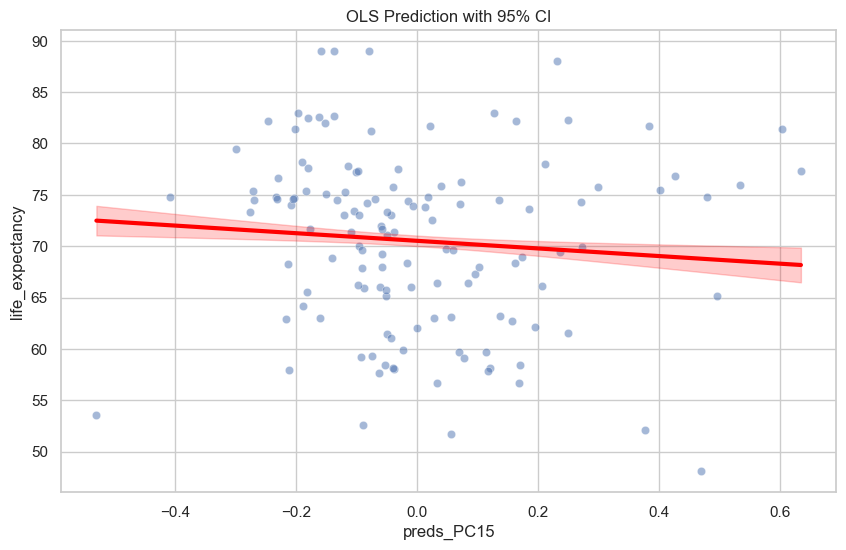

In [37]:
features = top_k.columns.drop(LECol.TARGET)
for feat in features:
    pred_plot(model, feat, top_k)


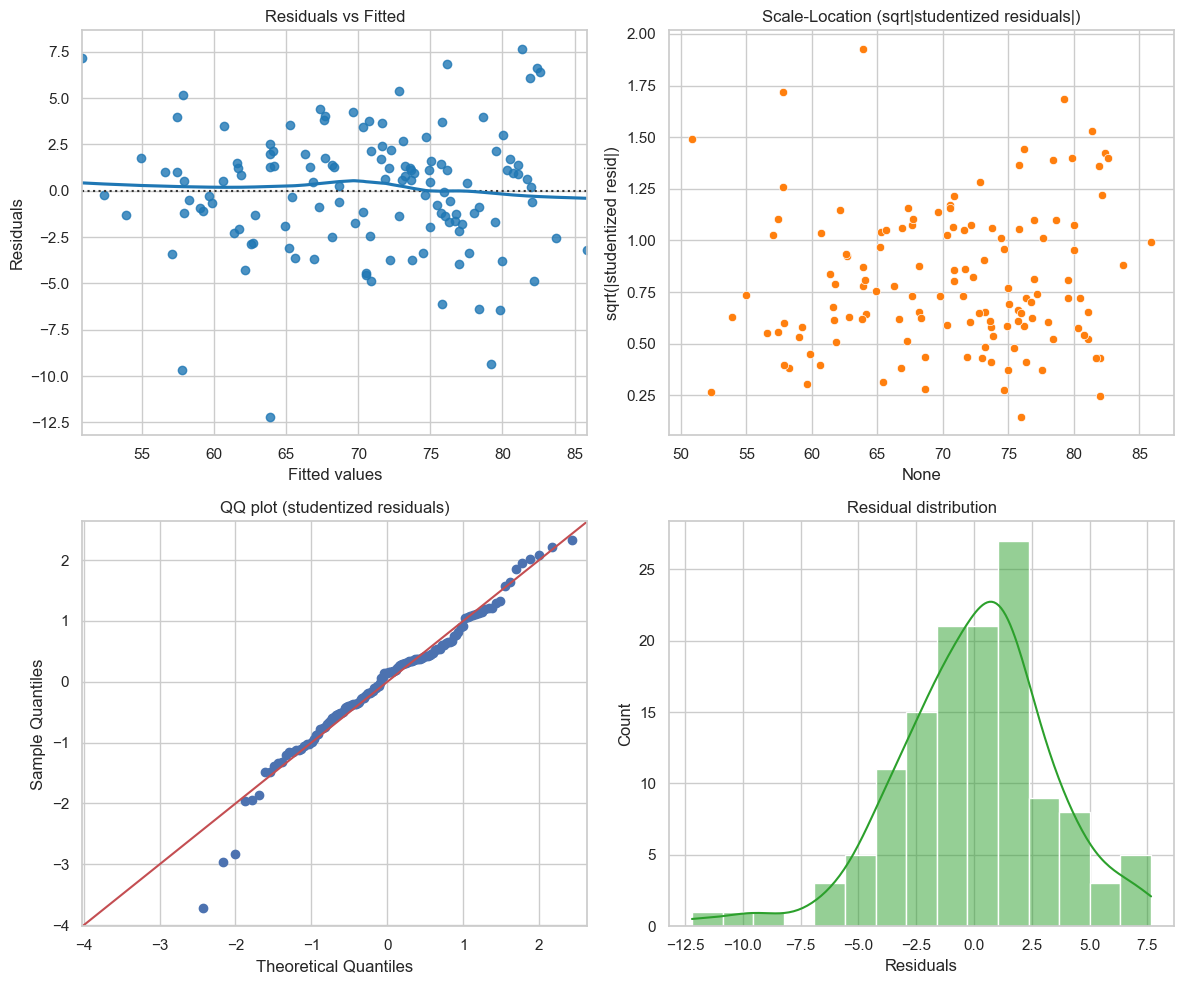

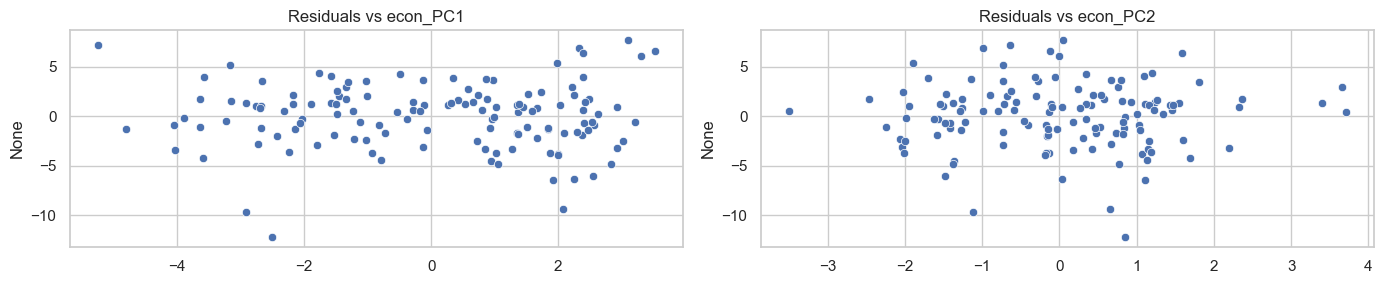

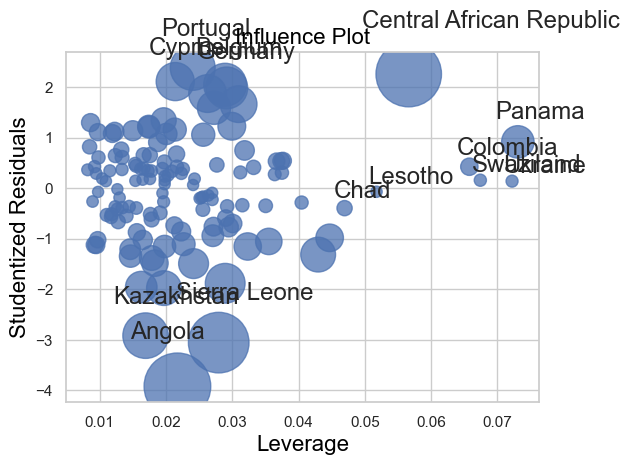

In [ ]:
predictors = pc_econ.columns.tolist()
predictors.remove(LECol.TARGET)
residual_diagnostics(model, predictors=predictors)


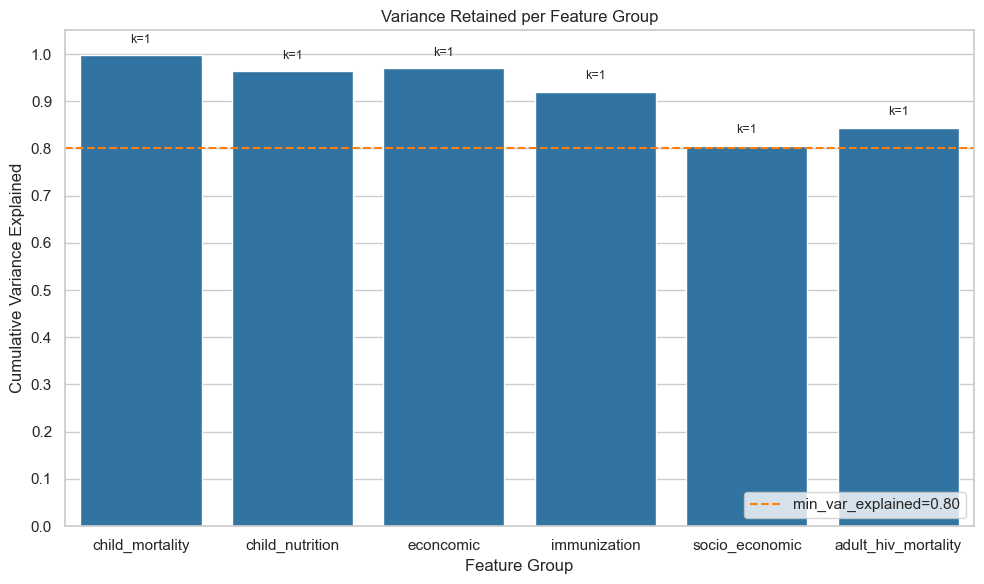

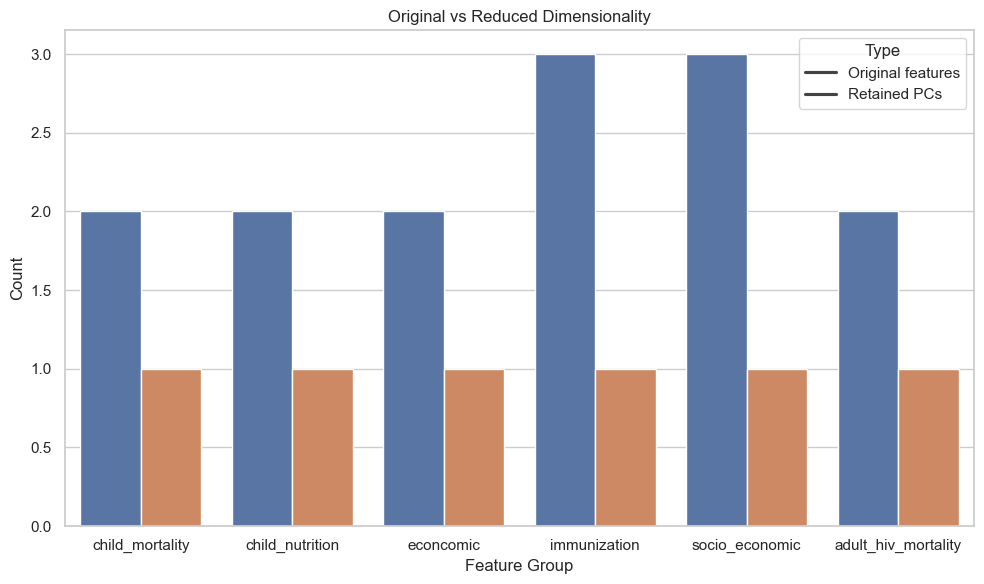

,child_mortality_PC1,child_nutrition_PC1,econcomic_PC1,immunization_PC1,socio_economic_PC1,adult_hiv_mortality_PC1,status,life_expectancy,measles,bmi,total_expenditure,population
country,,,,,,,,,,,,
Afghanistan,2.073520,2.836555,-0.721447,2.266651,-1.819016,0.308991,0,59.9,1.026147,-1.059125,0.821577,-0.532322
Albania,-1.307097,-1.377896,0.668036,-1.968879,1.122449,-1.385933,0,77.5,-0.941088,0.809728,-0.089841,-0.579813
Algeria,1.085805,0.864289,-0.870782,-0.838499,0.225845,-1.366599,0,75.4,-0.941088,0.867827,0.437196,1.275866
Angola,2.158789,1.482639,-1.204874,2.066512,-0.178041,2.137431,0,51.7,2.030888,-0.860620,-1.108252,0.264106
Argentina,0.317264,-1.663147,1.285113,-0.451660,2.308456,-0.677029,0,76.2,-0.721174,1.051807,-0.521774,1.311523


In [38]:
feature_groups = [
    FeatureGroup(
        name="child_mortality",
        features=[LECol.INFANT_DEATHS, LECol.UNDER_FIVE_DEATHS],
    ),
    FeatureGroup(
        name="child_nutrition",
        features=[LECol.THINNESS_5_9_YEARS, LECol.THINNESS_1_19_YEARS],
    ),
    FeatureGroup(
        name="econcomic",
        features=[LECol.GDP, LECol.PERCENTAGE_EXPENDITURE],
    ),
    FeatureGroup(
        name="immunization", features=[LECol.POLIO, LECol.DIPHTHERIA, LECol.HEPATITIS_B]
    ),
    FeatureGroup(
        name="socio_economic",
        features=[LECol.SCHOOLING, LECol.INCOME_COMPOSITION, LECol.ALCOHOL],
    ),
    FeatureGroup(
        "adult_hiv_mortality", features=[LECol.ADULT_MORTALITY, LECol.HIV_AIDS]
    ),
]


reduced_columns = [feature for g in feature_groups for feature in g.features]

dim_red_result = (
    LifeExpectancyDataset(df=df)
    .make_pca_dim_reduction_analyzer(
        feature_groups=feature_groups, standardized=True, min_var_explained=0.8
    )
    .fit()
    .result()
)

fig1 = plot_group_variance_summary(dim_red_result, figsize=(10, 6))
fig2 = plot_group_compression(dim_red_result, figsize=(10, 6))
plt.show()


pc_df = dim_red_result.reduced_df
pc_df = pc_df.assign(**df.drop(columns=reduced_columns))
pc_df.head()


Correlation matrix for df_dimred_small_0.8:


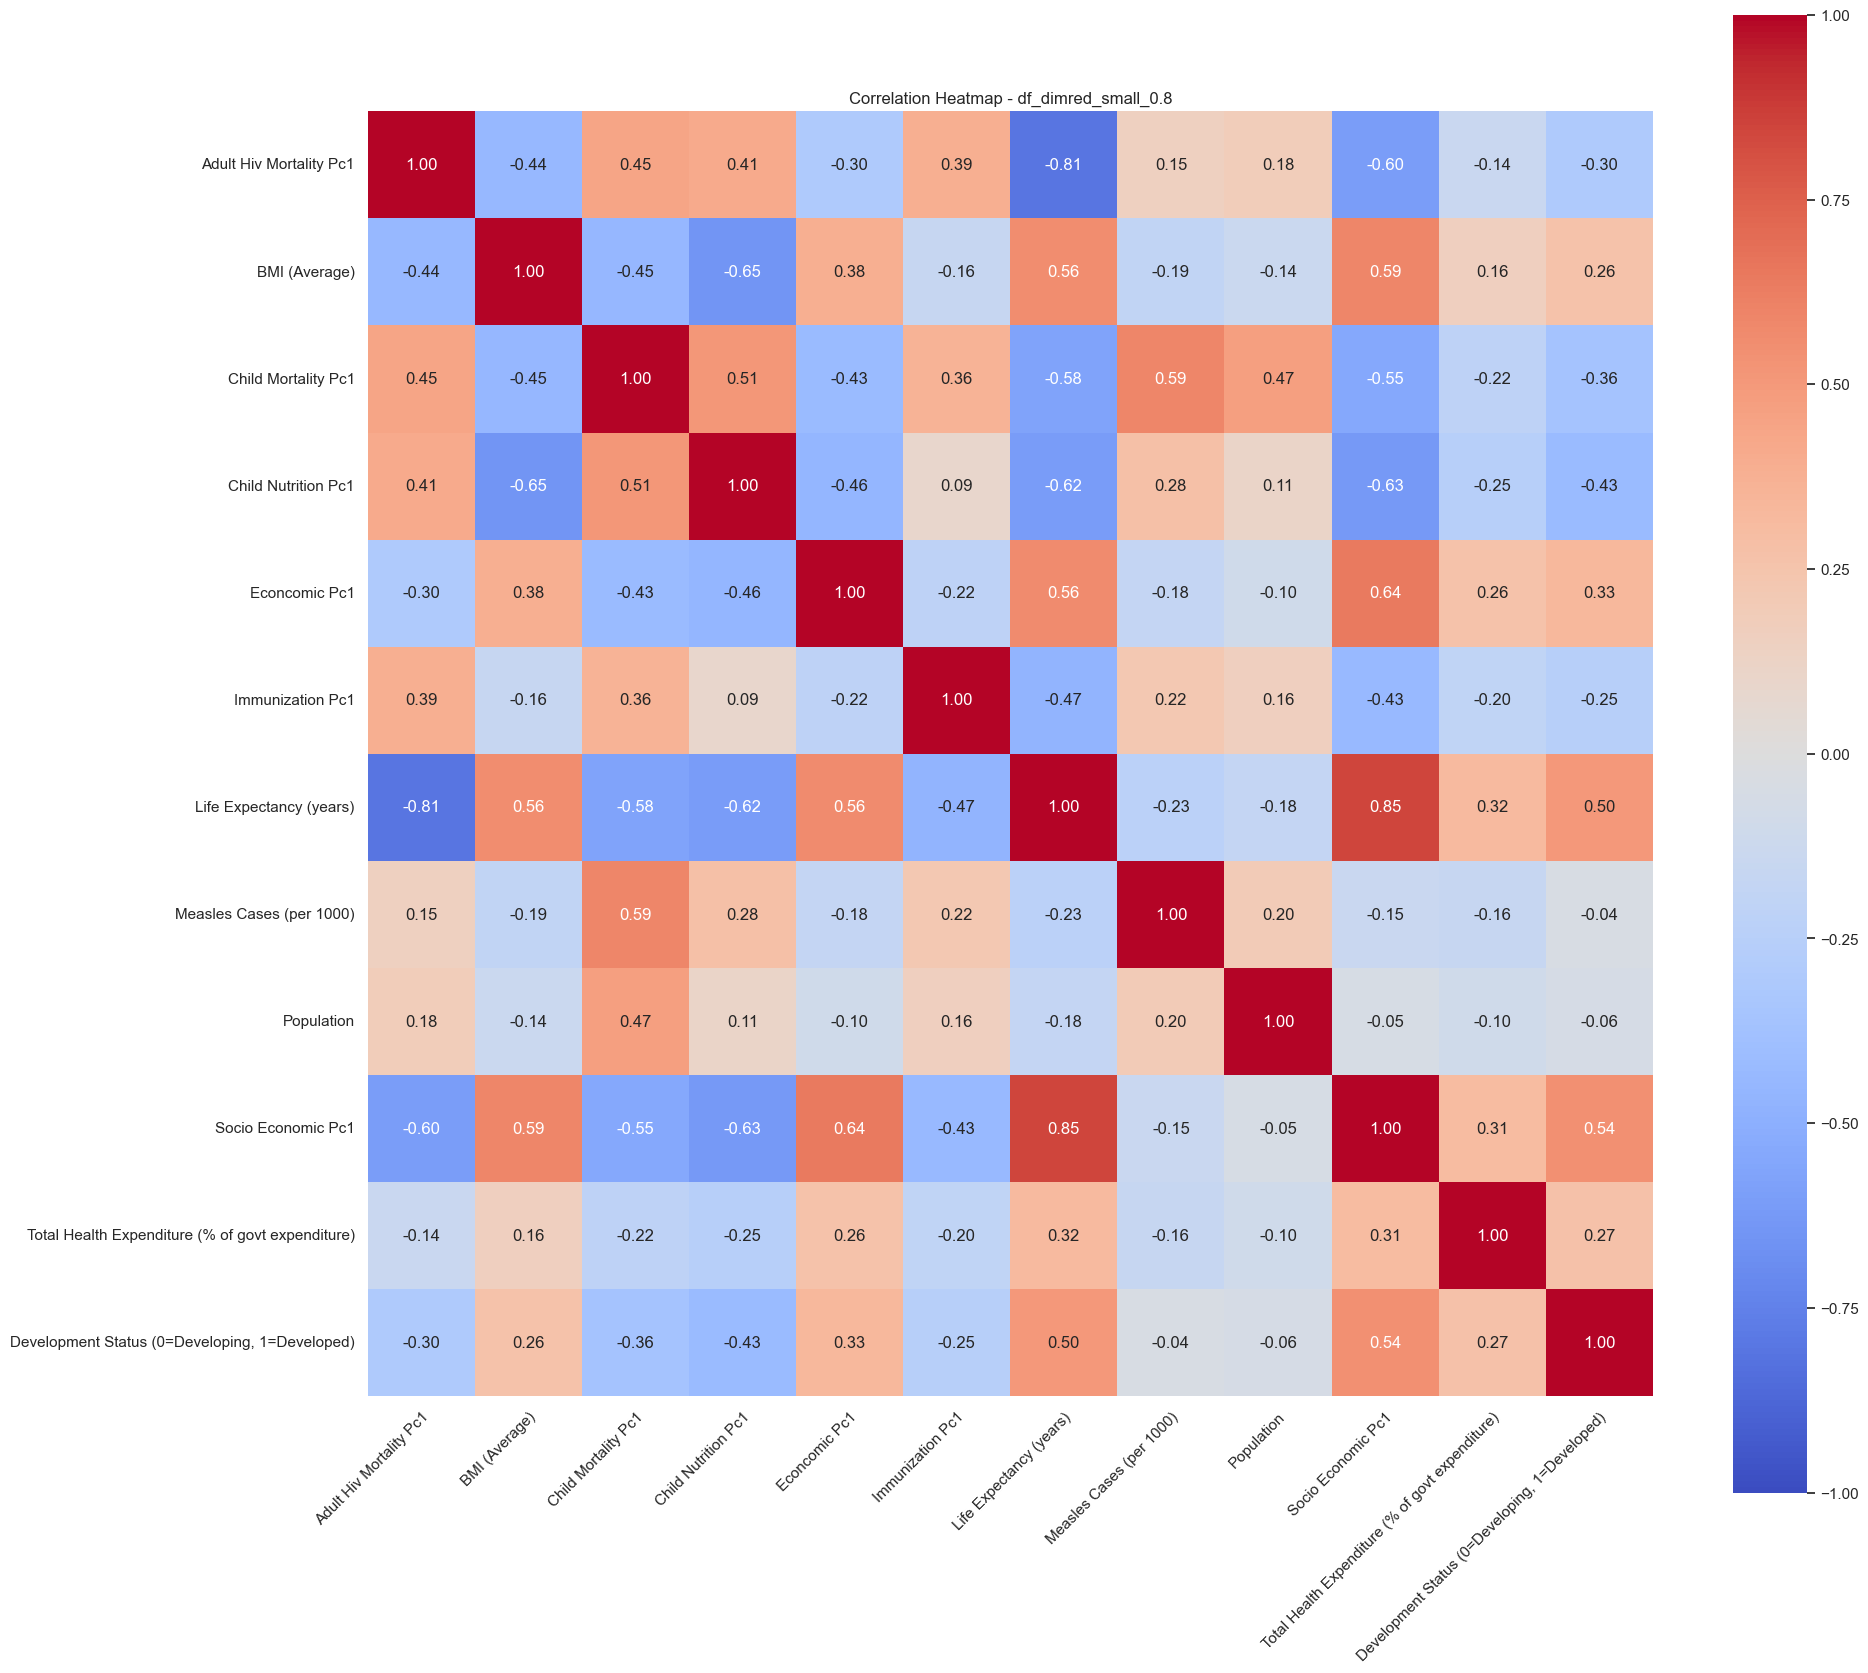


------------------------------------------------------------------------------------------------------------------------



In [39]:
dfs_dict = {
    "df_dimred_small_0.8": pc_df,
}

corr_dict = {
    name: LifeExpectancyDataset(df=df_).make_correlation_analyzer().fit().result()
    for name, df_ in dfs_dict.items()
}
for name, corr_ in corr_dict.items():
    print(f"Correlation matrix for {name}:")
    plot_correlation_heatmap(corr_)
    plt.title(f"Correlation Heatmap - {name}")
    plt.show()
    print("\n" + "-" * 120 + "\n")


- `child_mortality_PC1` still has a strong correlation with `population`. However, `population` only has a weak correlation with the target `life_expectancy`(4%), so we can simply drop it from the regression. 
- Similarly, `Measeles` has a correlation of 5%, but it could be semantically grouped with `child_mortality`

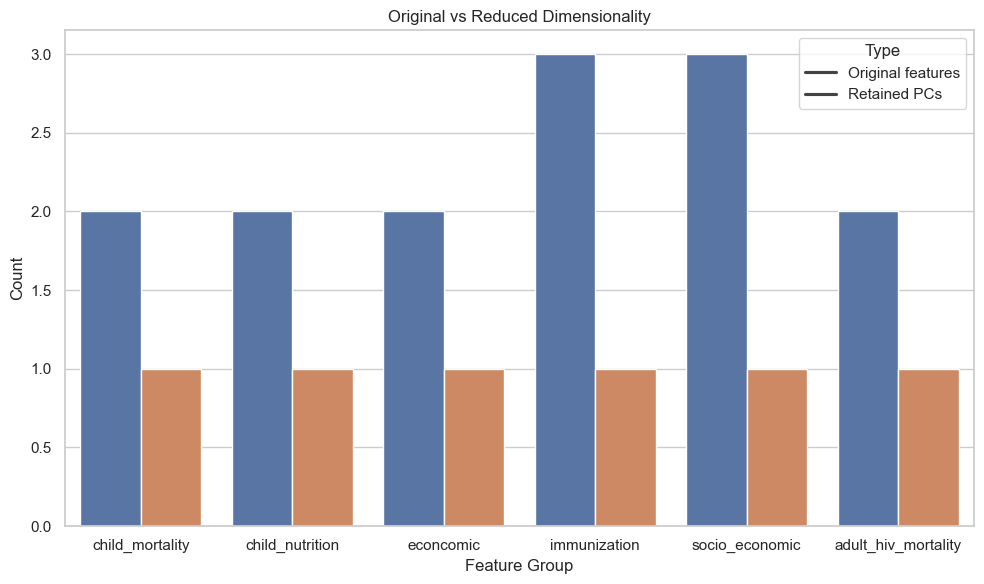

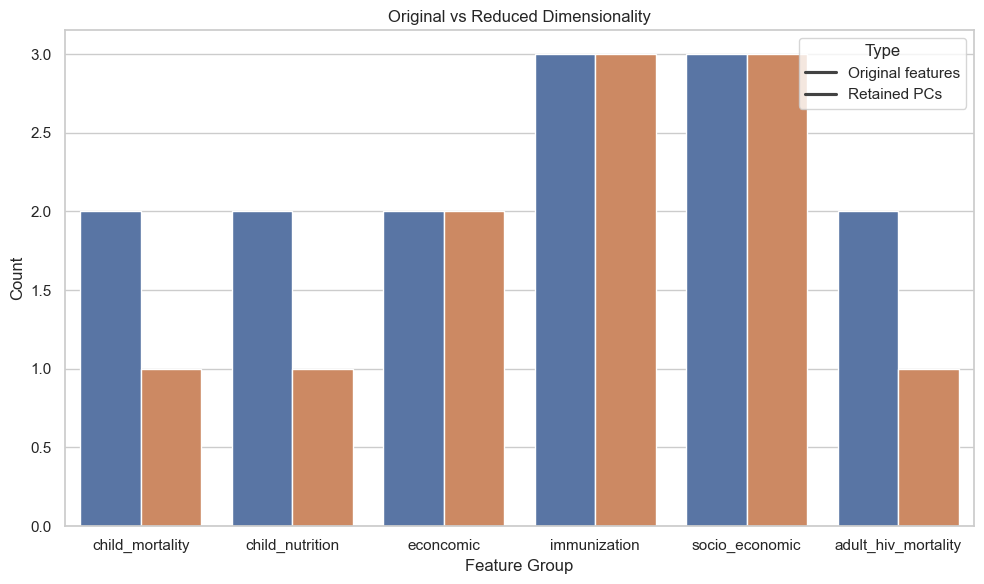

In [ ]:
feature_groups = [
    FeatureGroup(
        name="child_mortality",
        features=[LECol.INFANT_DEATHS, LECol.UNDER_FIVE_DEATHS],
    ),
    FeatureGroup(
        name="child_nutrition",
        features=[LECol.THINNESS_5_9_YEARS, LECol.THINNESS_1_19_YEARS],
    ),
    FeatureGroup(
        name="econcomic",
        features=[LECol.GDP, LECol.PERCENTAGE_EXPENDITURE],
    ),
    FeatureGroup(
        name="immunization", features=[LECol.POLIO, LECol.DIPHTHERIA, LECol.HEPATITIS_B]
    ),
    FeatureGroup(
        name="socio_economic",
        features=[LECol.SCHOOLING, LECol.INCOME_COMPOSITION, LECol.ALCOHOL],
    ),
    FeatureGroup(
        "adult_hiv_mortality", features=[LECol.ADULT_MORTALITY, LECol.HIV_AIDS]
    ),
]

transforms = {
    # LECol.ADULT_MORTALITY: lambda x: x, instead of log1p
    # alcohol: log1p, strong cluster at 0
    # QUESTION: bmi, set two knots!?
    # LECol.DIPHTHERIA: default from life_expectancy_columns (0.34 -> 0.49)
}

reduced_columns = [feature for g in feature_groups for feature in g.features]

dim_red_result = (
    LifeExpectancyDataset(df=df)
    .make_pca_dim_reduction_analyzer(
        feature_groups=feature_groups, standardized=True, min_var_explained=0.8
    )
    .fit()
    .result()
)

fig2 = plot_group_compression(dim_red_result, figsize=(10, 6))
plt.show()


pc_df = dim_red_result.reduced_df
pc_df = pc_df.assign(**df.drop(columns=reduced_columns))
dfs_dict["df_dimred_ext_0.8"] = pc_df
dim_red_result = (
    LifeExpectancyDataset(df=df)
    .make_pca_dim_reduction_analyzer(
        feature_groups=feature_groups, standardized=True, min_var_explained=1.0
    )
    .fit()
    .result()
)

fig2 = plot_group_compression(dim_red_result, figsize=(10, 6))
plt.show()


pc_df = dim_red_result.reduced_df
pc_df = pc_df.assign(**df.drop(columns=reduced_columns))
dfs_dict["df_dimred_ext_1.0"] = pc_df


In [ ]:
feature_groups = [
    FeatureGroup(
        name="child_mortality",
        features=[LECol.INFANT_DEATHS, LECol.UNDER_FIVE_DEATHS, LECol.MEASLES],
    ),
    FeatureGroup(
        name="child_nutrition",
        features=[LECol.THINNESS_5_9_YEARS, LECol.THINNESS_1_19_YEARS],
    ),
    FeatureGroup(
        name="econcomic",
        features=[LECol.GDP, LECol.PERCENTAGE_EXPENDITURE],
    ),
    FeatureGroup(
        name="immunization", features=[LECol.POLIO, LECol.DIPHTHERIA, LECol.HEPATITIS_B]
    ),
    FeatureGroup(
        name="socio_economic",
        features=[LECol.SCHOOLING, LECol.INCOME_COMPOSITION, LECol.ALCOHOL],
    ),
    FeatureGroup(
        "adult_hiv_mortality", features=[LECol.ADULT_MORTALITY, LECol.HIV_AIDS]
    ),
]


reduced_columns = [feature for g in feature_groups for feature in g.features]

dim_red_result = (
    LifeExpectancyDataset(df=)
    .make_pca_dim_reduction_analyzer(
        feature_groups=feature_groups, standardized=True, min_var_explained=0.8
    )
    .fit()
    .result()
)

fig2 = plot_group_compression(dim_red_result, figsize=(10, 6))
plt.show()


pc_df = dim_red_result.reduced_df
pc_df = pc_df.assign(**df.drop(columns=reduced_columns))
dfs_dict["df_dimred_ext_0.8"] = pc_df
dim_red_result = (
    LifeExpectancyDataset(df=df)
    .make_pca_dim_reduction_analyzer(
        feature_groups=feature_groups, standardized=True, min_var_explained=1.0
    )
    .fit()
    .result()
)

fig2 = plot_group_compression(dim_red_result, figsize=(10, 6))
plt.show()


pc_df = dim_red_result.reduced_df
pc_df = pc_df.assign(**df.drop(columns=reduced_columns))
dfs_dict["df_dimred_ext_1.0"] = pc_df


SyntaxError: expected argument value expression (3743196344.py, line 30)

In [ ]:
ols_dict = dict.fromkeys(dfs_dict.keys())
for name, df_ in dfs_dict.items():
    X = df_.drop(columns=[LECol.TARGET])
    y = df_[LECol.TARGET]

    X = sm.add_constant(X)  # add intercept
    ols_dict[name] = sm.OLS(y, X).fit()
    print(f"OLS Summary for {name}:")
    print(ols_dict[name].summary())
    print("-" * 120 + "\n")


OLS Summary for df_dimred_small_0.8:
                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     79.42
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           1.98e-49
Time:                        11:54:32   Log-Likelihood:                -328.40
No. Observations:                 131   AIC:                             680.8
Df Residuals:                     119   BIC:                             715.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

# Model with PCs retaining 80% variance (df_dimred_ext_0.8)

- `socio_economic_PC1` (schooling + income composition): strong positive (t≈7.4, p<0.001).
- `adult_hiv_mortality_PC1`: strong negative (t=‑9.9, p<0.001).
- `total_expenditure`: suggestive positive effect (p≈0.066).

Interpretation: >80% of explained variance is essentially captured by two dimensions: “human development/education” vs “HIV‑mortality burden”. Other blocks add little incremental signal after othogonalization via PCA.

---

## Model fit on df with PCs retaining 80% variance

- `measles` is now included in the principal component `child_mortality_PC1`.
- 

* **$R^2$ = 0.847** 
* **Adj. $R^2$ = 0.836**
* **F-stat = 74.6** (model highly significant)
* **Durbin–Watson = 2.17** (no autocorrelation)
* **Cond. No. = 5.48** (low multicollinearity)

- almost every coefficient except **socio_economic_PC1** and **adult_hiv_mortality_PC1** is non-significant, which explain > 80% of the variance in life expectancy.
- **Cond. No. = 5.48** is good. So multicollinearity is **not** the reason the t-values are weak.

Each PC is:
  * standardized
  * orthogonal to other PCs
  * scaled to unit variance internally
  * encode the *shared direction of variation* and don't care about their correlation with the target within the component group.

---

## Model fit on df with all PCs retained

## Feature selection based on the model fit with retained PCs
- 


In [ ]:
def fit_ols(name: str, formula: str, data: pd.DataFrame):
    res = ols(formula=formula, data=data).fit()
    res.model_name = name
    return res


def aicc(res) -> float:
    k = res.params.size  # includes intercept
    n = res.nobs
    return res.aic + (2 * k * (k + 1)) / (n - k - 1)


def compare_models(models: dict[str, object]) -> pd.DataFrame:
    rows = []
    for name, res in models.items():
        rows.append(
            {
                "model": name,
                "aic": res.aic,
                "aicc": aicc(res),
                "bic": res.bic,
                "adj_r2": res.rsquared_adj,
                "rmse": np.sqrt(res.mse_resid),
            }
        )
    return pd.DataFrame(rows).sort_values("aicc").reset_index(drop=True)


Diagnostics for model: df_agg


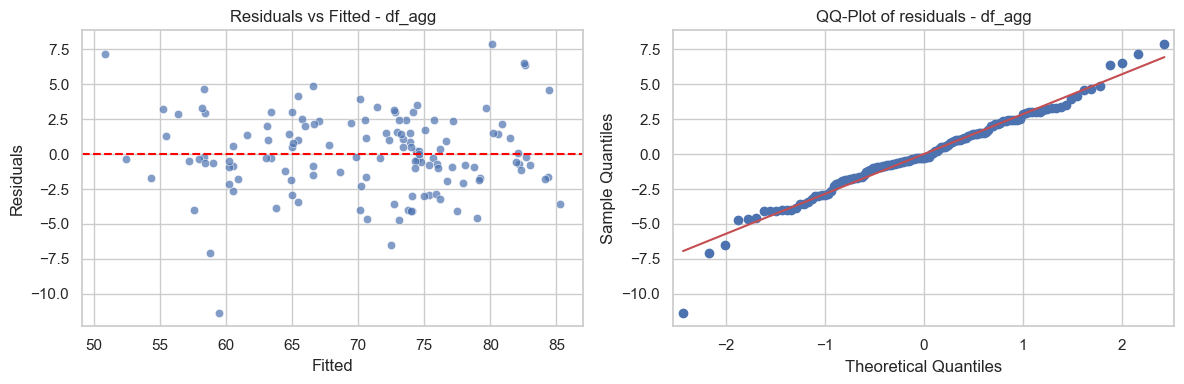


------------------------------------------------------------------------------------------------------------------------

Diagnostics for model: df_dimred


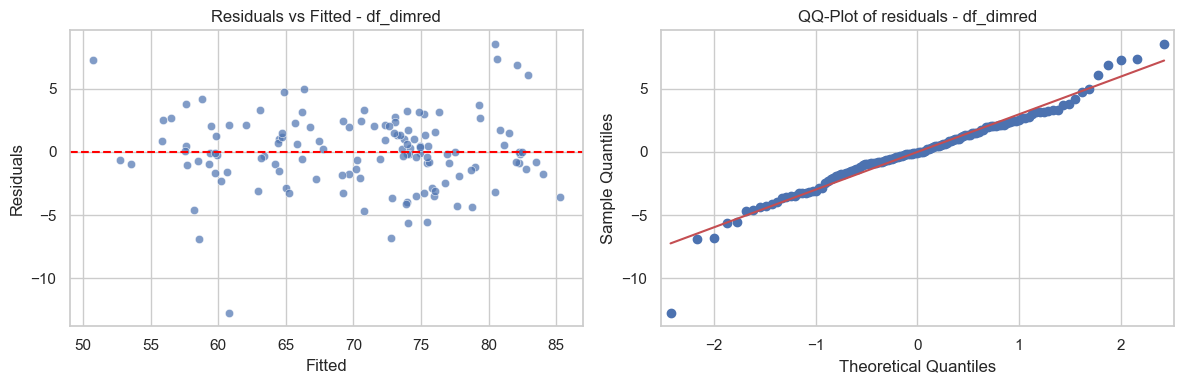


------------------------------------------------------------------------------------------------------------------------

Diagnostics for model: df_full


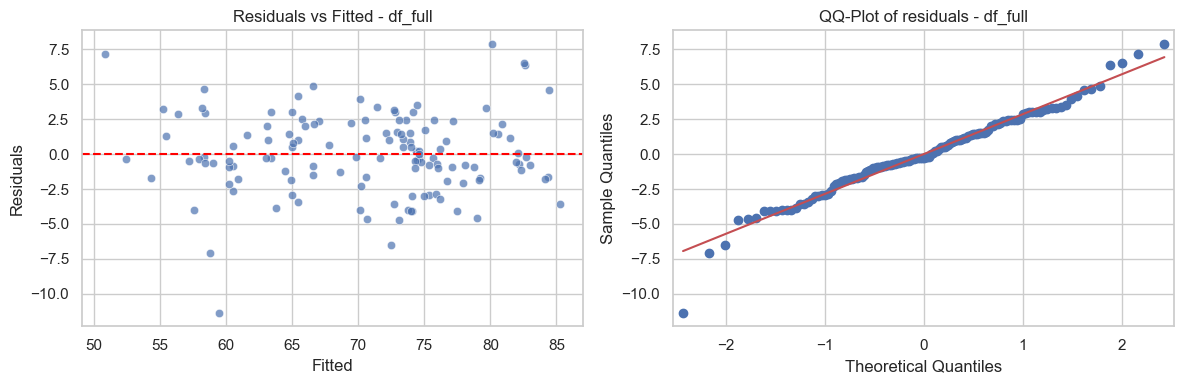


------------------------------------------------------------------------------------------------------------------------

Diagnostics for model: df_no_tf


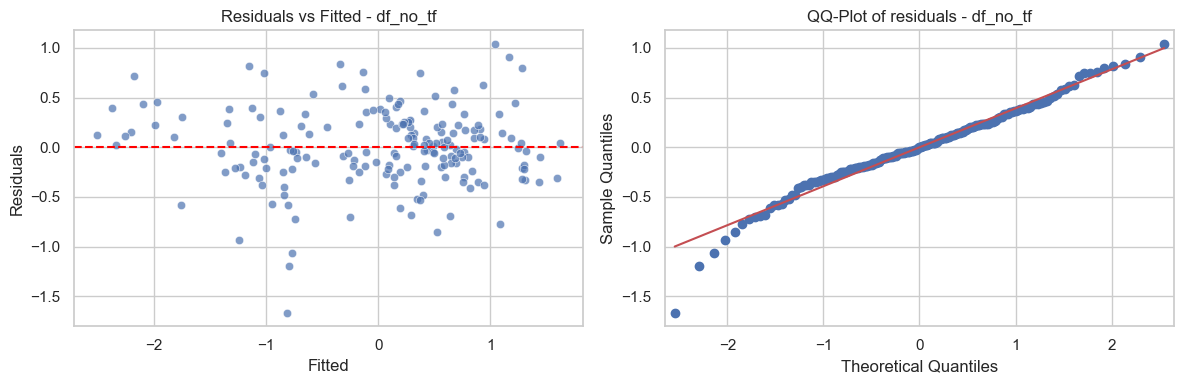


------------------------------------------------------------------------------------------------------------------------



In [ ]:
# Diagnostics: residuals + QQ

for name, model in ols_dict.items():
    print(f"Diagnostics for model: {name}")
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.scatterplot(x=model.fittedvalues, y=model.resid, ax=axes[0], alpha=0.7)
    axes[0].axhline(0, color="red", linestyle="--")
    axes[0].set_xlabel("Fitted")
    axes[0].set_ylabel("Residuals")
    axes[0].set_title(f"Residuals vs Fitted - {name}")

    sm.qqplot(model.resid, line="s", ax=axes[1])
    axes[1].set_title(f"QQ-Plot of residuals - {name}")
    plt.tight_layout()
    plt.show()
    print("\n" + "-" * 120 + "\n")


,model,aic,aicc,bic,adj_r2
3,df_no_tf,214.845679,219.508256,275.825916,0.829218
0,df_agg,686.773284,694.409648,744.277231,0.869939
2,df_full,686.773284,694.409648,744.277231,0.869939
1,df_dimred,692.012181,697.428110,740.890535,0.862017


/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_208/3164420408.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


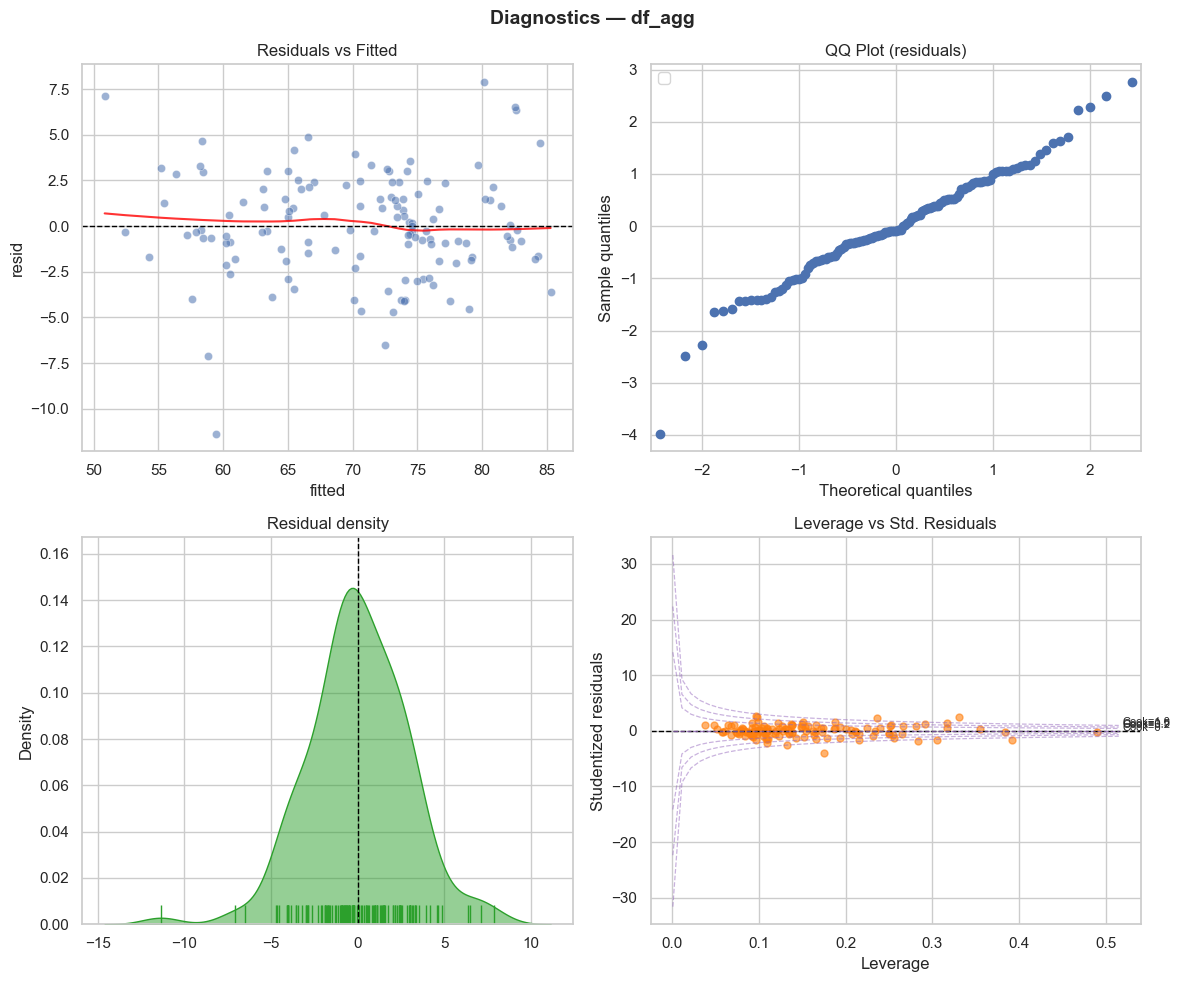

/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_208/3164420408.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


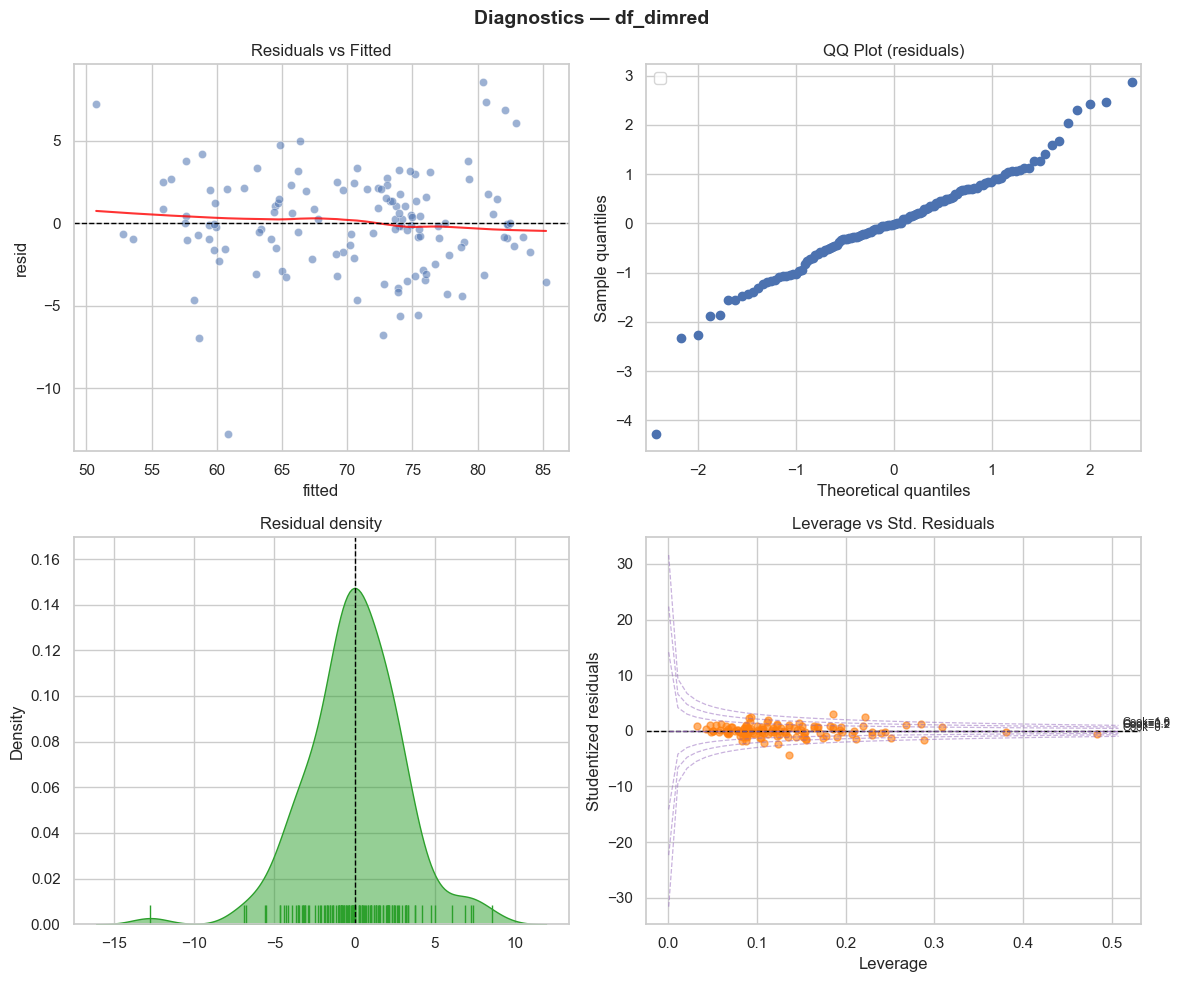

/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_208/3164420408.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


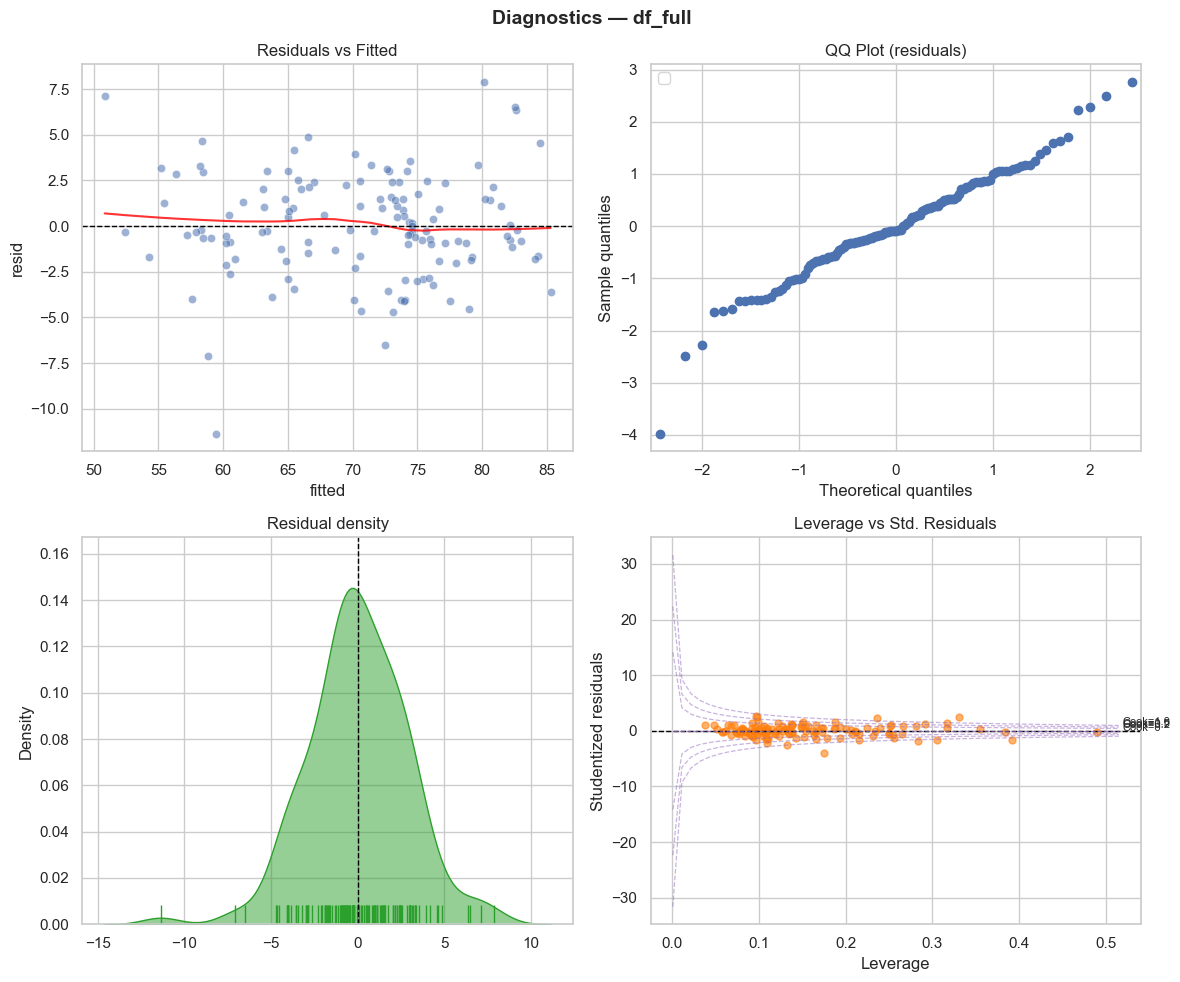

/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_208/3164420408.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


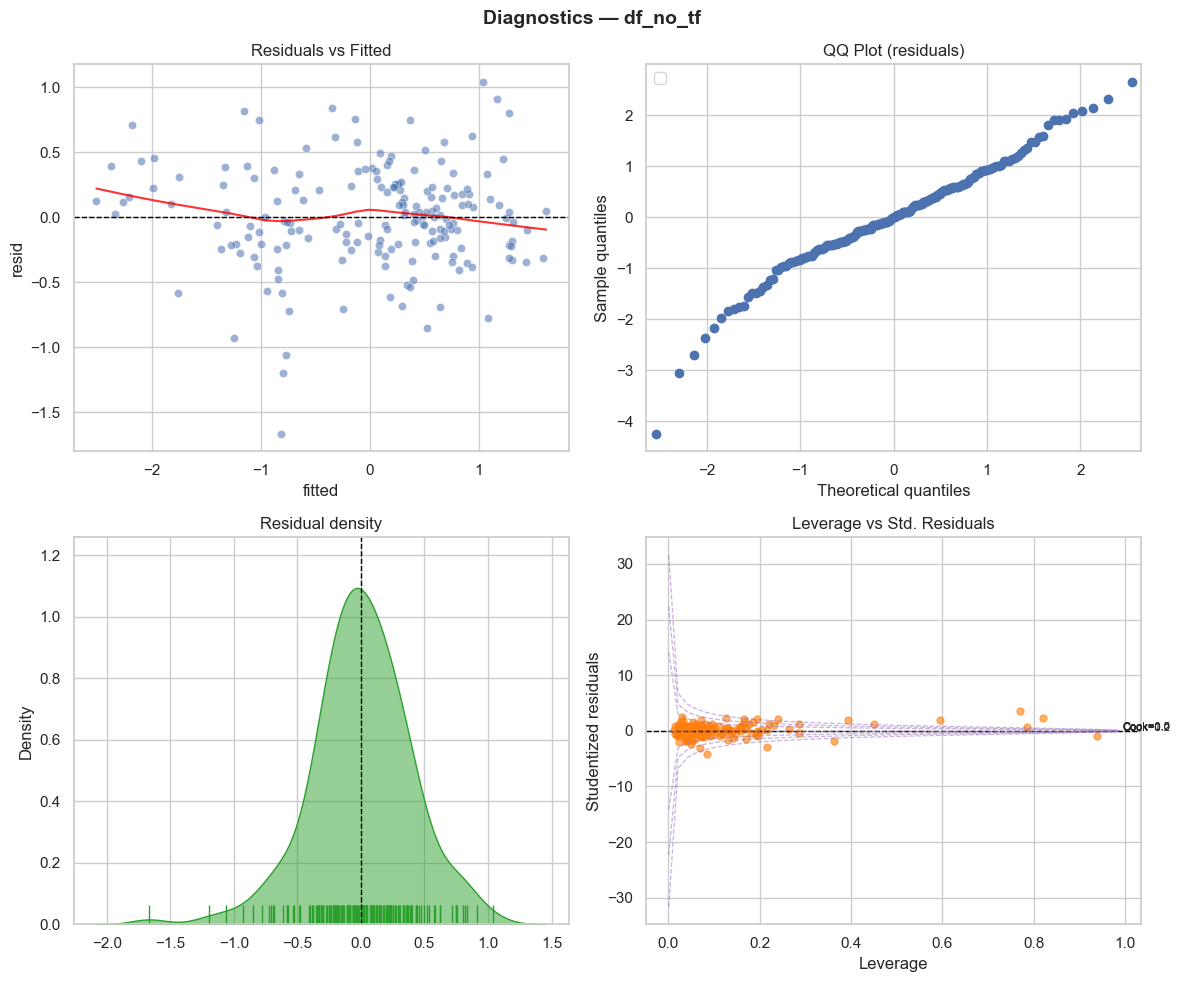

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot

sns.set_theme(style="whitegrid")


def aicc(res):
    k = res.params.size
    n = res.nobs
    return res.aic + (2 * k * (k + 1)) / max(n - k - 1, 1)


def cooksd_contours(ax, leverage, resid_studentized, line_coords=(0, 0.2, 0.5, 1.0)):
    # add Cook's distance contours to leverage plot
    for d in line_coords:
        x = np.linspace(0.001, leverage.max() * 1.05, 50)
        y = np.sqrt(d * (1 - x) / x)
        ax.plot(x, y, color="tab:purple", alpha=0.5, linestyle="--", linewidth=0.9)
        ax.plot(x, -y, color="tab:purple", alpha=0.5, linestyle="--", linewidth=0.9)
        ax.annotate(
            f"Cook={d}",
            xy=(x[-1], y[-1]),
            xytext=(3, 0),
            textcoords="offset points",
            fontsize=8,
        )


def plot_diagnostics(name, res):
    fitted = res.fittedvalues
    resid = res.resid
    stud_resid = res.get_influence().resid_studentized_internal
    leverage = res.get_influence().hat_matrix_diag
    df = pd.DataFrame(
        {
            "fitted": fitted,
            "resid": resid,
            "stud_resid": stud_resid,
            "leverage": leverage,
        }
    )

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Diagnostics — {name}", fontweight="bold", fontsize=14)

    # 1) Residuals vs Fitted with LOESS smoothing
    sns.scatterplot(data=df, x="fitted", y="resid", alpha=0.55, s=35, ax=axes[0, 0])
    sns.regplot(
        data=df,
        x="fitted",
        y="resid",
        scatter=False,
        lowess=True,
        line_kws={"color": "red", "lw": 1.5, "alpha": 0.8},
        ax=axes[0, 0],
    )
    axes[0, 0].axhline(0, color="black", linestyle="--", linewidth=1)
    axes[0, 0].set_title("Residuals vs Fitted")

    # 2) QQ plot with 95% band
    qq = ProbPlot(resid, fit=True)
    theo = qq.theoretical_quantiles
    sample = qq.sample_quantiles
    qq.qqplot(ax=axes[0, 1])

    # axes[0, 1].scatter(theo, sample, alpha=0.6, s=20, color="tab:blue")
    # axes[0, 1].plot(
    #     theo, slope * theo + intercept, color="red", lw=1.5, label="Fit line"
    # )
    # axes[0, 1].plot(theo, theo, color="black", lw=1, linestyle="--", label="45°")

    # # 95% CI (approx) from sm ProbPlot
    # ci = qq.probplot(sorted=True, fit=True)[1]
    axes[0, 1].set_title("QQ Plot (residuals)")
    axes[0, 1].set_xlabel("Theoretical quantiles")
    axes[0, 1].set_ylabel("Sample quantiles")
    axes[0, 1].legend()

    # 3) Density + rug of residuals
    sns.kdeplot(resid, fill=True, alpha=0.5, color="tab:green", ax=axes[1, 0])
    sns.rugplot(resid, height=0.05, color="tab:green", ax=axes[1, 0])
    axes[1, 0].axvline(0, color="black", linestyle="--", lw=1)
    axes[1, 0].set_title("Residual density")

    # 4) Leverage vs Studentized Residuals (Cook's contours)
    axes[1, 1].scatter(leverage, stud_resid, alpha=0.6, s=25, color="tab:orange")
    axes[1, 1].axhline(0, color="black", linestyle="--", lw=1)
    axes[1, 1].set_xlabel("Leverage")
    axes[1, 1].set_ylabel("Studentized residuals")
    axes[1, 1].set_title("Leverage vs Std. Residuals")
    cooksd_contours(axes[1, 1], leverage, stud_resid)

    plt.tight_layout()
    plt.show()


# Compare AICc across your three fits
aicc_table = pd.DataFrame(
    {
        "model": list(ols_dict.keys()),
        "aic": [m.aic for m in ols_dict.values()],
        "aicc": [aicc(m) for m in ols_dict.values()],
        "bic": [m.bic for m in ols_dict.values()],
        "adj_r2": [m.rsquared_adj for m in ols_dict.values()],
    }
).sort_values("aicc")
display(aicc_table)

# Run diagnostics for each model
for name, res in ols_dict.items():
    plot_diagnostics(name, res)


In [ ]:
ds_raw = LifeExpectancyDataset.from_csv(aggregate_by_country=False)
tf_map = {}
df = ds_raw.tf_and_norm()


df_supervised = (
    df
    # tf to multi-index
    .reset_index()
    .set_index([LECol.COUNTRY, LECol.YEAR])  # MultiIndex
    .sort_index()
    # 1-year lag of life expectancy per country
    .assign(
        **{
            f"{LECol.TARGET}_lag1": lambda d: d.groupby(level=LECol.COUNTRY)[
                LECol.TARGET
            ].shift(1)
        }
    )
    .dropna(subset=[f"{LECol.TARGET}_lag1"])
    .reset_index()
)

# Choose features: multivariate + lag + time
feature_cols = [
    *LECol.numeric_columns(),
    f"{LECol.TARGET}_lag1",
]
feature_cols.remove(LECol.TARGET)

X_core = df_supervised[feature_cols]

# Add country fixed effects and a linear time trend
X_feat = pd.concat(
    [
        X_core,
        # pd.get_dummies(
        #     df_supervised[LECol.COUNTRY],
        #     prefix="country",
        #     drop_first=True,
        #     dtype=np.int16,
        # ),
        df_supervised[[LECol.YEAR]].assign(
            year=df_supervised[LECol.YEAR].dt.year
            - df_supervised[LECol.YEAR].dt.year.min()
        ),  # numeric time trend
    ],
    axis=1,
)
assert LECol.TARGET not in X_feat.columns

y = df_supervised[LECol.TARGET]

# X_feat = sm.add_constant(X_feat)

X_feat


,status,adult_mortality,infant_deaths,under_five_deaths,hiv_aids,measles,hepatitis_b,polio,diphtheria,bmi,...,thinness_5_9_years,gdp,percentage_expenditure,total_expenditure,income_composition_of_resources,schooling,alcohol,population,life_expectancy_lag1,year
0,0,0.963092,1.604029,1.596697,-0.528429,1.774583,1.051928,1.809145,1.890502,-1.292702,...,-0.399992,-1.458792,-1.277920,0.802229,-1.592887,-2.225730,-1.122948,0.367326,54.8,0
1,0,-3.215871,1.604029,1.596697,-0.528429,1.386863,1.027605,1.794843,1.847206,-1.272448,...,-0.483893,-1.191660,-1.051085,0.784828,-1.587424,-2.118378,-1.122948,1.096465,55.3,1
2,0,0.897585,1.597172,1.596697,-0.528429,1.037313,1.002616,1.719862,1.770399,-1.252193,...,2.113200,-1.159546,-1.255263,1.245961,-1.412592,-2.011026,-1.122948,0.284808,56.2,2
3,0,0.891106,1.597172,1.587334,-0.528429,0.871990,0.950485,2.160142,2.221401,-1.231938,...,2.099893,-1.103768,-1.099639,1.232910,-1.368884,-1.903673,-1.120465,1.130276,56.7,3
4,0,0.884582,1.583221,1.577815,-0.528429,1.186448,0.976923,1.407786,1.450724,-1.211683,...,2.086457,-2.321754,-2.100324,1.193757,-1.286932,-1.510049,-1.120465,-0.522072,57.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,0,1.450692,0.944137,1.022418,2.871532,1.805761,1.858361,0.212208,0.226030,-0.441995,...,0.784195,-0.428835,-0.472316,-0.254895,-1.068392,-0.758583,0.168026,0.115730,50.0,9
1512,0,1.329261,0.923564,0.996453,2.677605,-1.020133,-0.490957,-0.167615,-0.163042,-0.416676,...,0.731300,-0.335558,-0.380669,0.154034,-0.980976,-0.722799,0.364155,0.942163,52.4,10
1513,0,1.254474,0.880200,0.955149,2.205281,-1.020133,-1.001352,-0.437103,-0.439093,-1.763630,...,0.676302,-0.261657,-0.188624,0.319345,-0.915414,-0.830151,0.386499,0.112163,54.9,11
1514,0,1.185356,0.857298,0.910623,1.919971,-1.020133,-0.631550,-0.437103,-0.439093,-1.738311,...,0.599396,-1.489951,-1.273795,0.402001,-0.784291,-0.615447,0.460978,-0.706221,56.6,12


In [ ]:
model = sm.OLS(y, X_feat)
res = model.fit()

print(res.summary())


                                 OLS Regression Results                                
Dep. Variable:        life_expectancy   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.206e+05
Date:                Thu, 04 Dec 2025   Prob (F-statistic):                        0.00
Time:                        16:31:15   Log-Likelihood:                         -2957.4
No. Observations:                1516   AIC:                                      5957.
Df Residuals:                    1495   BIC:                                      6069.
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [ ]:
res.resid


0       0.235256
1       0.845243
2       0.456615
3       0.274173
4       0.122559
          ...   
1511    1.557636
1512    1.787233
1513    0.903895
1514    0.602066
1515    0.549558
Length: 1516, dtype: float64

In [ ]:
ds_raw = LifeExpectancyDataset.from_csv(aggregate_by_country=False)
tf_map = {}
df = ds_raw.tf_and_norm()


df_supervised = (
    df
    # tf to multi-index
    .reset_index()
    .set_index([LECol.COUNTRY, LECol.YEAR])  # MultiIndex
    .sort_index()
    # 1-year lag of life expectancy per country
    .assign(
        **{
            f"{LECol.TARGET}_lag1": lambda d: d.groupby(level=LECol.COUNTRY)[
                LECol.TARGET
            ].shift(1)
        }
    )
    .dropna(subset=[f"{LECol.TARGET}_lag1"])
    .reset_index()
)

# Choose features: multivariate + lag + time
feature_cols = [
    *LECol.numeric_columns(),
    # f"{LECol.TARGET}_lag1",
]
feature_cols.remove(LECol.TARGET)

X_core = df_supervised[feature_cols]

# Add country fixed effects and a linear time trend
X_feat = pd.concat(
    [
        X_core,
        # pd.get_dummies(
        #     df_supervised[LECol.COUNTRY],
        #     prefix="country",
        #     drop_first=True,
        #     dtype=np.int8,
        # ),
        df_supervised[[LECol.YEAR]].assign(
            year=df_supervised[LECol.YEAR].dt.year
            - df_supervised[LECol.YEAR].dt.year.min()
        ),  # numeric time trend
    ],
    axis=1,
)

y = df_supervised[LECol.TARGET]

# X_feat = sm.add_constant(X_feat)

X_feat


,status,adult_mortality,infant_deaths,under_five_deaths,hiv_aids,measles,hepatitis_b,polio,diphtheria,bmi,thinness_1_19_years,thinness_5_9_years,gdp,percentage_expenditure,total_expenditure,income_composition_of_resources,schooling,alcohol,population,year
0,0,0.963092,1.604029,1.596697,-0.528429,1.774583,1.051928,1.809145,1.890502,-1.292702,-0.520310,-0.399992,-1.458792,-1.277920,0.802229,-1.592887,-2.225730,-1.122948,0.367326,0
1,0,-3.215871,1.604029,1.596697,-0.528429,1.386863,1.027605,1.794843,1.847206,-1.272448,2.139003,-0.483893,-1.191660,-1.051085,0.784828,-1.587424,-2.118378,-1.122948,1.096465,1
2,0,0.897585,1.597172,1.596697,-0.528429,1.037313,1.002616,1.719862,1.770399,-1.252193,2.125603,2.113200,-1.159546,-1.255263,1.245961,-1.412592,-2.011026,-1.122948,0.284808,2
3,0,0.891106,1.597172,1.587334,-0.528429,0.871990,0.950485,2.160142,2.221401,-1.231938,2.112074,2.099893,-1.103768,-1.099639,1.232910,-1.368884,-1.903673,-1.120465,1.130276,3
4,0,0.884582,1.583221,1.577815,-0.528429,1.186448,0.976923,1.407786,1.450724,-1.211683,2.098412,2.086457,-2.321754,-2.100324,1.193757,-1.286932,-1.510049,-1.120465,-0.522072,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,0,1.450692,0.944137,1.022418,2.871532,1.805761,1.858361,0.212208,0.226030,-0.441995,0.818110,0.784195,-0.428835,-0.472316,-0.254895,-1.068392,-0.758583,0.168026,0.115730,9
1512,0,1.329261,0.923564,0.996453,2.677605,-1.020133,-0.490957,-0.167615,-0.163042,-0.416676,0.765518,0.731300,-0.335558,-0.380669,0.154034,-0.980976,-0.722799,0.364155,0.942163,10
1513,0,1.254474,0.880200,0.955149,2.205281,-1.020133,-1.001352,-0.437103,-0.439093,-1.763630,0.710863,0.676302,-0.261657,-0.188624,0.319345,-0.915414,-0.830151,0.386499,0.112163,11
1514,0,1.185356,0.857298,0.910623,1.919971,-1.020133,-0.631550,-0.437103,-0.439093,-1.738311,0.653977,0.599396,-1.489951,-1.273795,0.402001,-0.784291,-0.615447,0.460978,-0.706221,12


- TODO: Maybe use group-wise indicator for countrie (i.e. continent / region)
- 

In [ ]:
model = sm.OLS(y, X_feat)
res = model.fit()

print(res.summary())


                                 OLS Regression Results                                
Dep. Variable:        life_expectancy   R-squared (uncentered):                   0.818
Model:                            OLS   Adj. R-squared (uncentered):              0.816
Method:                 Least Squares   F-statistic:                              336.7
Date:                Thu, 04 Dec 2025   Prob (F-statistic):                        0.00
Time:                        16:31:16   Log-Likelihood:                         -7301.2
No. Observations:                1516   AIC:                                  1.464e+04
Df Residuals:                    1496   BIC:                                  1.475e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error

X = X_feat
X.columns = X.columns.map(lambda x: x.value if isinstance(x, LECol) else x)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

y_pred_test = rf.predict(X_test)
print("R2 (test):", r2_score(y_test, y_pred_test))
print("RMSE (test9):", root_mean_squared_error(y_test, y_pred_test))


R2 (test): 0.9564601999523168
RMSE (test9): 1.662449655175799


In [ ]:
rf


,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False
